In [17]:
import os
import sys
import time
import calendar
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

def read_prices(directory, start_year, end_year):
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                  'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    filenames = []
    for year in range(start_year, end_year + 1):
        for month in month_order:
            filename = f"ERCOT_{month}_{year}.csv"
            filepath = os.path.join(directory, filename)
            if os.path.exists(filepath):
                filenames.append(filepath)
    p_list = []
    times_list = []
    for file in filenames:
        df = pd.read_csv(file, usecols=['lmp_dam', 'interval_start_utc'], dtype={'lmp_dam': 'float64'})
        p_list.append(df['lmp_dam'].values)
        times_list.append(pd.to_datetime(df['interval_start_utc']))
    p = np.concatenate(p_list)
    return p

def repeat_single_year_data_with_leap_years(p, start_year=2000, end_year=2029):
    new_p_list = []
    for year in range(start_year, end_year + 1):
        if calendar.isleap(year):
            new_p_list.append(p)
        else:
            # Remove entries corresponding to February 29th
            p_non_leap = np.concatenate((p[:1416], p[1440:]))
            new_p_list.append(p_non_leap)
    new_p = np.concatenate(new_p_list)
    return new_p

def horizon(x, H):
    number_of_samples = len(x) - H
    future = np.zeros((number_of_samples,H))
    c = 0
    for i in range(len(x) - H):
        future_slice = x[i:i+H]
        future[c] = future_slice
        c += 1
    return future

def generate_intervals_2_weeks(year):
    intervals = []
    for month in [1,6]:
        start_time = f"{year}-{month:02d}-01 00:00"
        end_time = f"{year}-{month:02d}-07 23:00"
        intervals.append((start_time, end_time))
    return intervals

directory = '../ercot/prices'
single_year_prices = read_prices(directory, 2012, 2012)
single_year_times = pd.date_range(start='2012-01-01 00:00', end='2012-12-31 23:00', freq='h')
start_year = 2012
end_year = 2036
prices = repeat_single_year_data_with_leap_years(single_year_prices, start_year, end_year)
times = pd.date_range(start=f'{start_year}-01-01 00:00', end=f'{end_year}-12-31 23:00', freq='h')
assert len(prices) == len(times)
H = 24
f_test = horizon(prices, H)

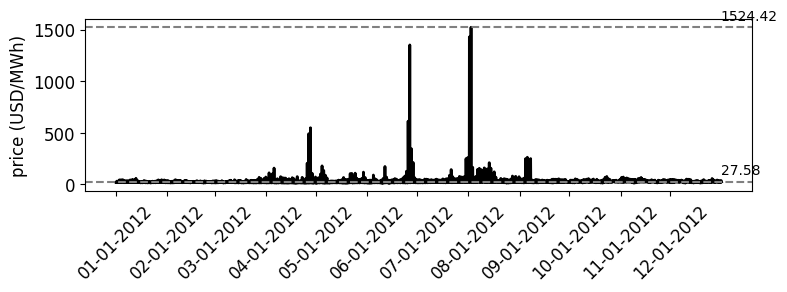

In [18]:
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'prices_ERCOT_2012.pdf'
file_path = os.path.join(output_dir, file_name)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(single_year_times, single_year_prices, label='price', color='black', linewidth=2)
ax.set_ylabel(f'price (USD/MWh)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(False)
ax.axhline(y=np.mean(single_year_prices), color='gray', linestyle='--', label='mean')
ax.axhline(y=np.max(single_year_prices), color='gray', linestyle='--', label='max')
ax.annotate(f'{np.mean(single_year_prices):.2f}', xy=(single_year_times[-10], np.mean(single_year_prices)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=10)
ax.annotate(f'{np.max(single_year_prices):.2f}', xy=(single_year_times[-10], np.max(single_year_prices)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=10)
ax.set_xticks(pd.date_range(start=single_year_times.min(), end=single_year_times.max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%m-%d-%Y'))
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

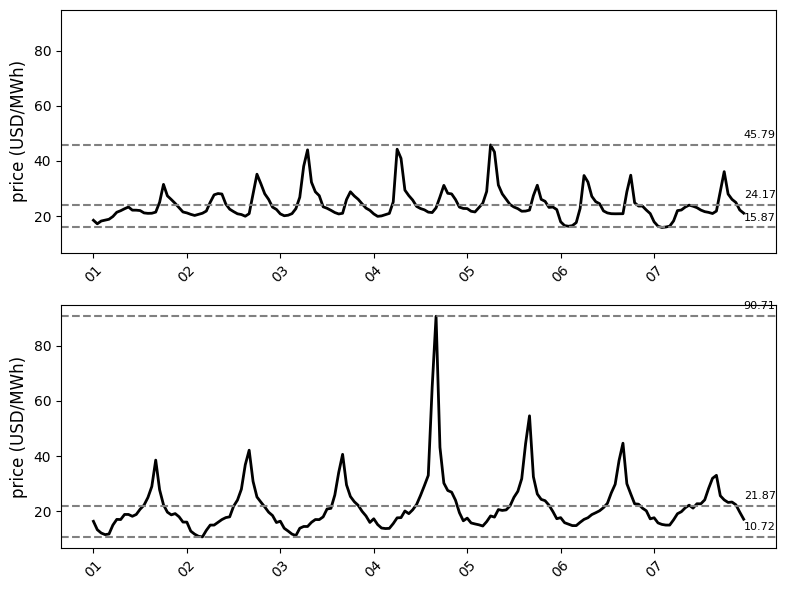

In [19]:
intervals = generate_intervals_2_weeks(2012)
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'prices_ERCOT_2012_weekly.pdf'
file_path = os.path.join(output_dir, file_name)
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey=True)
axes = axes.flatten()
for idx, (start_time, end_time) in enumerate(intervals):
    mask = (times >= start_time) & (times <= end_time)
    p_subset = prices[mask]
    times_subset = times[mask]
    ax = axes[idx]
    if len(p_subset) > 0:
        ax.plot(times_subset, p_subset, label='Price', color='black', linewidth=2)
        ax.set_ylabel('price (USD/MWh)', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(False)
        ax.axhline(y=np.mean(p_subset), color='gray', linestyle='--')
        ax.axhline(y=np.max(p_subset), color='gray', linestyle='--')
        ax.axhline(y=np.min(p_subset), color='gray', linestyle='--')
        if len(times_subset) >= 10:
            ax.annotate(f'{np.mean(p_subset):.2f}', xy=(times_subset[-1], np.mean(p_subset)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=8)
            ax.annotate(f'{np.max(p_subset):.2f}', xy=(times_subset[-1], np.max(p_subset)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=8)
            ax.annotate(f'{np.min(p_subset):.2f}', xy=(times_subset[-1], np.min(p_subset)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=8)
    ax.set_xticks(pd.date_range(start=start_time, end=end_time, freq='d'))
    ax.xaxis.set_major_formatter(DateFormatter('%d'))
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

In [20]:
cell_constants = {
    'H' : H,
    'C_max' : 0.33, # 1/h
    'tilde_Q_1' : 2.5, # Ah
    'tilde_V' : 3.3, # V
    'N' : 0.5, # divided by 1e6
    'cons_z': 0.60,
    'cons_alpha': 28.966,
    'cons_beta': 74.112,
    'cons_delta': 1,
    'cons_eta': 152.5,
    'cons_E_a': 31500,
    'cons_R_g': 8.314,
    'cons_T': 273.15 + 25, # K
    'cons_omega': np.exp(-31500 / (8.314 * (273.15 + 25))),
        # --- NEW ---
    'SoH_target': 0.80          # required remaining capacity at end of each horizon
    }

def aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False):
    mu_t = cell_constants['cons_beta'] * cell_constants['cons_omega'] * cell_constants['cons_z'] * np.power(ah_t, cell_constants['cons_z'] - 1)
    nu_t = 0 if tilde_Q_t == 0 else cell_constants['cons_alpha'] / (cell_constants['cons_beta'] * tilde_Q_t)
    lambda_t = 0 if tilde_Q_t == 0 else cell_constants['cons_eta'] / (cell_constants['cons_R_g'] * cell_constants['cons_T'] * tilde_Q_t)
    if approx == False:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * tilde_q_t)) * np.exp(lambda_t * abs(tilde_b_t))
    else:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * (tilde_Q_t/2)))
    Sigma_rho_t = Sigma_rho_t + rho_t
    l_t = Sigma_rho_t * cell_constants['cons_delta']
    tilde_Q_t = cell_constants['tilde_Q_1'] * (1 - l_t)
    return l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t

def arbitrage_problem(cell_constants):
    H = cell_constants['H']

    # ------------- PARAMETERS -------------
    p_H               = cp.Parameter((H,), nonneg=True, name='p_H')
    tilde_Q_t         = cp.Parameter(nonneg=True, name='tilde_Q_t')
    tilde_Q_target    = cp.Parameter(nonneg=True, name='tilde_Q_target')
    tilde_B_t         = cp.Parameter(nonneg=True, name='tilde_B_t')
    tilde_q_t_1       = cp.Parameter(nonneg=True, name='tilde_q_t_1')
    aging_coeff_t     = cp.Parameter(nonneg=True, name='aging_coeff_t')
    mu                = cp.Parameter(nonneg=True, name='mu')
    SoH_target        = cp.Parameter(nonneg=True, name='SoH_target')   # ★ NEW ★

    # ------------- VARIABLES --------------
    tilde_q           = cp.Variable(H+1, nonneg=True, name='tilde_q')
    tilde_b           = cp.Variable(H,     name='tilde_b')
    tilde_delta_q_t   = cp.Variable(name='tilde_delta_q_t')

    # ------------- OBJECTIVE --------------
    objective = (1/H) * (
        -cp.sum(cp.multiply(p_H,
                            tilde_b*cell_constants['cons_delta']
                                   *cell_constants['tilde_V']
                                   *cell_constants['N']))
        + aging_coeff_t*1e5*cp.sum(cp.abs(tilde_b))
    ) + mu * cp.sum_squares(tilde_delta_q_t)

    # ------------- CONSTRAINTS -------------
    constraints = [
        cp.diff(tilde_q) == -tilde_b*cell_constants['cons_delta'],
        cp.abs(tilde_b)  <=  tilde_B_t,
        tilde_q[1:]      <=  tilde_Q_t,
        tilde_q[0]       ==  tilde_q_t_1,
        tilde_delta_q_t  ==  tilde_q[-1] - tilde_Q_target,
        # ★ Terminal-SoH constraint ★
        tilde_q[-1]      >=  SoH_target * cell_constants['tilde_Q_1']
    ]

    return cp.Problem(cp.Minimize(objective), constraints)


def arbitrage_set_parameter_values(prob, p_H, tilde_Q_t, tilde_q_t_1,
                                   tilde_Q_target, tilde_B_t,
                                   aging_coeff_t, mu, SoH_target):
    prob.param_dict['p_H'].value            = p_H
    prob.param_dict['tilde_Q_t'].value      = tilde_Q_t
    prob.param_dict['tilde_q_t_1'].value    = tilde_q_t_1
    prob.param_dict['tilde_Q_target'].value = tilde_Q_target
    prob.param_dict['tilde_B_t'].value      = tilde_B_t
    prob.param_dict['aging_coeff_t'].value  = aging_coeff_t
    prob.param_dict['mu'].value             = mu
    prob.param_dict['SoH_target'].value     = SoH_target      # ★ NEW ★
    return prob

def arbitrage_retrieve(problem):
    tilde_b = problem.var_dict['tilde_b'].value
    tilde_q = problem.var_dict['tilde_q'].value
    tilde_delta_q_t = problem.var_dict['tilde_delta_q_t'].value
    return tilde_b, tilde_q, tilde_delta_q_t

In [21]:
def arbitrage_experiment(f_test, cell_constants, cons_frac, cons_mu, cons_gamma):
    # Shapes
    E = f_test.shape[0]
    H = f_test.shape[1]
    # Problem
    problem = arbitrage_problem(cell_constants)
    # Pre-allocate battery-level variables
    revenue = np.zeros((E,)) # USD
    p = np.zeros((E,)) # MW
    hat_p = np.zeros((E,H))
    # Pre-allocate cell-level variables
    tilde_b = np.zeros((E,)) # A
    tilde_q = np.zeros((E,)) # Ah
    tilde_delta_q = np.zeros((E,))
    tilde_hat_q = np.zeros((E,H))
    tilde_Q = np.ones((E,)) * cell_constants['tilde_Q_1'] # Ah
    l = np.zeros((E,))
    ah = np.zeros((E,))
    mu_one_plus_nu_q = np.zeros((E,))
    Sigma_rho = np.zeros((E,))
    # Initialize cell-level variables
    tilde_Q_t = tilde_Q[0]
    tilde_Q_target = cons_frac*tilde_Q_t
    tilde_q_t = tilde_Q_t
    tilde_q_t_1 = tilde_Q_t
    tilde_B_t = cell_constants['C_max'] * tilde_Q_t
    tilde_b_t = 0
    # Initialize cell-level running variables
    ah_t = 2.5
    Sigma_rho_t = 0
    # Initialize aging
    l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False)
    mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5*tilde_Q_t))
    aging_coefficient_t = cons_gamma * mu_one_plus_nu_q_t
    # -----------------------------------LOOP-----------------------------------
    for e in range(E):    
        hat_p[e] = f_test[e]
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break


        SoH_target_val = 0.80                    # 80 % 
        problem =        arbitrage_set_parameter_values(
                   problem, f_test[e], tilde_Q_t, tilde_q_t_1,
                   tilde_Q_target, tilde_B_t, aging_coefficient_t,
                   cons_mu, cell_constants['SoH_target'])

        try:
            problem.solve(solver=cp.CLARABEL, verbose=False)
        except cp.error.SolverError:          # numerical failure, etc.
            print(f"Warning: cp.error.SolverError for {e}")
            return None                       # tell the caller to skip this γ

        if problem.status not in ["optimal", "optimal_inaccurate"]:
            # MPC became infeasible because of the terminal-SoH constraint
            print(f"Warning: infeasible terminal-SoH constraint for {e}")
            return None


        tilde_b_H, tilde_q_H, tilde_delta_q_t = arbitrage_retrieve(problem)
        # Update battery-level variables
        p_t = f_test[e][0]
        tilde_hat_q[e] = tilde_q_H[1:]
        tilde_b_t = tilde_b_H[0]
        revenue_t = p_t*tilde_b_t*cell_constants['cons_delta']*cell_constants['tilde_V']*cell_constants['N']
        # Update running variables
        ah_t = ah_t + (abs(tilde_b_t)*cell_constants['cons_delta'])
        #------------------------
        tilde_q_t = tilde_q_H[1]
        tilde_q_t_1 = tilde_q_H[1]
        # Update aging
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False)
        mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5*tilde_Q_t))
        aging_coefficient_t = cons_gamma * mu_one_plus_nu_q_t
        tilde_B_t = cell_constants['C_max']*tilde_Q_t
        tilde_Q_target = cons_frac*tilde_Q_t
        # Assign battery-level variables
        p[e] = p_t
        revenue[e] = revenue_t
        # Assign cell-level variables
        tilde_b[e] = tilde_b_t
        tilde_q[e] = tilde_q_t
        tilde_Q[e] = tilde_Q_t
        tilde_delta_q[e] = tilde_delta_q_t
        l[e] = l_t
        ah[e] = ah_t
        mu_one_plus_nu_q[e] = mu_one_plus_nu_q_t
        Sigma_rho[e] = Sigma_rho_t
    
    # ----------------------------END LOOP----------------------------
    num_hours = e
    # Trim battery-level variables
    revenue = revenue[:num_hours]
    p = p[:num_hours]
    hat_p = hat_p[:num_hours]
    # Gross metrics
    battery_lifetime = num_hours/(365*24*(1/cell_constants['cons_delta']))
    ah_at_the_end = ah[num_hours-1]
    # Trim cell-level variables
    tilde_b = tilde_b[:num_hours]
    tilde_Q = tilde_Q[:num_hours]
    tilde_q = tilde_q[:num_hours]
    tilde_delta_q = tilde_delta_q[:num_hours]
    tilde_hat_q = tilde_hat_q[:num_hours]
    l = l[:num_hours]
    ah = ah[:num_hours]
    mu_one_plus_nu_q = mu_one_plus_nu_q[:num_hours]
    Sigma_rho = Sigma_rho[:num_hours]
    # Battery-level variables
    battery_variables = {'revenue': revenue, 'p': p, 'hat_p': hat_p}
    # Cell-level variables
    cell_variables = {'tilde_b': tilde_b, 
                      'tilde_Q': tilde_Q, 
                      'tilde_q': tilde_q, 
                      'tilde_delta_q': tilde_delta_q, 
                      'tilde_hat_q': tilde_hat_q, 
                      'l': l, 
                      'ah': ah, 
                      'mu_one_plus_nu_q': mu_one_plus_nu_q,
                      'Sigma_rho': Sigma_rho}
    

    return battery_variables, cell_variables, battery_lifetime, ah_at_the_end

import time
import numpy as np

def experiment_loop(
    f_test,
    cell_constants,
    gammas=None,
    cons_frac=0.5,
    cons_mu=0.0,
    continue_on_fail=True,   # 失败是否继续
    fail_policy="nan"        # 失败占位策略: "nan" -> 用 np.nan/None 占位；"skip" -> 直接跳过不加入列表
):
    """
    运行一组 gamma 扫描实验，鲁棒处理 arbitrage_experiment 返回 None/异常的情况。
    返回: bvs, cvs, bls, ahs（长度与成功/占位一致；若 fail_policy='skip' 则为成功项长度）
    """
    if gammas is None:
        # gammas = np.logspace(0, 3.5, 10)
        gammas = np.linspace(0, 30, 9)

    num_experiments = len(gammas)
    bvs, cvs, bls, ahs = [], [], [], []
    failed = 0

    def _parse_result(ret):
        # None 直接判失败
        if ret is None:
            return None
        # 字典返回：取常用键名
        if isinstance(ret, dict):
            b = ret.get("battery_variables")
            c = ret.get("cell_variables")
            bl = ret.get("battery_lifetime")
            ah = ret.get("ah_at_the_end") or ret.get("ah_end") or ret.get("Ah_end")
            if (b is not None) and (c is not None) and (bl is not None) and (ah is not None):
                return b, c, bl, ah
            else:
                return None
        # 元组/列表返回：期望 4 元
        if isinstance(ret, (tuple, list)):
            if len(ret) == 4:
                return ret[0], ret[1], ret[2], ret[3]
            elif len(ret) == 3:
                # 兜底：少了最后一个值的话用 nan 占位
                b, c, bl = ret
                return b, c, bl, np.nan
            else:
                return None
        # 其他类型：不支持
        return None

    for j, cons_gamma in enumerate(gammas, start=1):
        start_time = time.time()
        try:
            ret = arbitrage_experiment(f_test, cell_constants, cons_frac, cons_mu, cons_gamma)
            parsed = _parse_result(ret)
            if parsed is None:
                raise ValueError("arbitrage_experiment returned None or unexpected structure")
            battery_variables, cell_variables, battery_lifetime, ah_at_the_end = parsed

            bvs.append(battery_variables)
            cvs.append(cell_variables)
            bls.append(battery_lifetime)
            ahs.append(ah_at_the_end)

            status = "ok"
        except Exception as e:
            failed += 1
            status = f"FAIL: {e}"
            if not continue_on_fail:
                # 直接抛出，保持原有行为
                raise
            if fail_policy == "nan":
                # 用占位保持列表长度一致
                bvs.append(None)
                cvs.append(None)
                bls.append(np.nan)
                ahs.append(np.nan)
            elif fail_policy == "skip":
                # 不加入任何条目
                pass
            else:
                # 未知策略，默认占位
                bvs.append(None)
                cvs.append(None)
                bls.append(np.nan)
                ahs.append(np.nan)

        end_time = time.time()
        print(f'Experiment {j}/{num_experiments} (gamma={cons_gamma:.4g}) -> {status} '
              f'in {end_time - start_time:.2f}s')

    if failed:
        print(f"[WARN] {failed}/{num_experiments} experiments failed.")

    return bvs, cvs, bls, ahs


In [22]:
bvs, cvs, bls, ahs = experiment_loop(f_test, cell_constants)

print(bvs, cvs, bls, ahs)

# ─── 仅保留 SoH 约束可行的实验 ───

feasible = [i for i, bv in enumerate(bvs) if bv is not None]
bvs  = [bvs[i]  for i in feasible]
cvs  = [cvs[i]  for i in feasible]
bls  = [bls[i]  for i in feasible]
ahs  = [ahs[i]  for i in feasible]


Experiment 1/9 (gamma=0) -> ok in 253.34s
Experiment 2/9 (gamma=3.75) -> ok in 330.66s
Experiment 3/9 (gamma=7.5) -> ok in 352.62s
Experiment 4/9 (gamma=11.25) -> ok in 393.81s
Experiment 5/9 (gamma=15) -> ok in 451.57s
Experiment 6/9 (gamma=18.75) -> ok in 531.57s
Experiment 7/9 (gamma=22.5) -> ok in 603.15s
Experiment 8/9 (gamma=26.25) -> ok in 674.22s
Experiment 9/9 (gamma=30) -> ok in 763.27s
[{'revenue': array([ 2.51695124e+01, -2.34072238e+01,  6.70088140e-03, ...,
       -1.81565016e+01, -1.74580860e+01, -1.72374615e+01]), 'p': array([18.49, 17.2 , 18.21, ..., 14.82, 14.25, 14.07]), 'hat_p': array([[18.49, 17.2 , 18.21, ..., 24.59, 23.06, 21.49],
       [17.2 , 18.21, 18.53, ..., 23.06, 21.49, 21.15],
       [18.21, 18.53, 18.85, ..., 21.49, 21.15, 20.63],
       ...,
       [14.82, 14.25, 14.07, ..., 18.31, 16.31, 15.01],
       [14.25, 14.07, 16.4 , ..., 16.31, 15.01, 14.75],
       [14.07, 16.4 , 16.1 , ..., 15.01, 14.75, 14.79]])}, {'revenue': array([4.59771171e-09, 3.096601

In [37]:
# ====== 样式与导出工具（全局通用） ======
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

lifetimes = np.asarray(bls, dtype=float)

# 色弱友好固定调色板
COLORS = {
    'black':   '#000000',
    'blue':    '#0072B2',
    'orange':  '#D55E00',
    'green':   '#009E73',
    'magenta': '#CC79A7',
    'red':     '#D62728',
    'purple':  '#7E2F8E'
}

# 全局 rcParams：大字号/粗线/大标记
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 15,
    'legend.fontsize': 14,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'lines.linewidth': 2.5,     # 线宽 2–3
    'lines.markersize': 6.5,    # 标记 5–7
    'savefig.dpi': 300,
})

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

def save_vec_and_png(fig, path_no_ext):
    fig.savefig(path_no_ext + '.pdf', bbox_inches='tight')       # 矢量 PDF
    fig.savefig(path_no_ext + '.png', dpi=600, bbox_inches='tight')  # 600 dpi PNG

# ====== 取数据并单位换算（保持你已有逻辑） ======
k = 1
battery_variables = bvs[k]
cell_variables    = cvs[k]

revenue   = battery_variables['revenue']
p         = battery_variables['p']        # day-ahead price
hat_p     = battery_variables['hat_p']    # (如需)
tilde_b   = cell_variables['tilde_b']     # 电芯侧功率（A·?）——下行换算至 MWh
tilde_q   = cell_variables['tilde_q']
tilde_Q   = cell_variables['tilde_Q']
tilde_delta_q = cell_variables['tilde_delta_q']
tilde_hat_q   = cell_variables['tilde_hat_q']
l         = cell_variables['l']
ah        = cell_variables['ah']
mu_one_plus_nu_q = cell_variables['mu_one_plus_nu_q']
Sigma_rho       = cell_variables['Sigma_rho']

# 统一换算（与原代码一致）：将电芯功率序列换算为“(近似)能量/MWh”
tilde_b = tilde_b * cell_constants['cons_delta'] * cell_constants['tilde_V'] * cell_constants['N']

# 可选：如果有 NN 的闭环功率序列（同维度），一并绘制
tilde_b_nn = None
# 例如：tilde_b_nn = battery_variables.get('tilde_b_nn', None)
# 若存在，记得同样换算：
# if tilde_b_nn is not None:
#     tilde_b_nn = tilde_b_nn * cell_constants['cons_delta'] * cell_constants['tilde_V'] * cell_constants['N']

# ====== 输出目录 ======
output_dir = "./figures"
ensure_dir(output_dir)

# ====== 4) Arbitrage：周视图（价格 vs 功率；双轴双图例） ======
times_jan = pd.date_range(start='2012-01-01 00:00', end='2012-01-07 23:00', freq='h')
times_jun = pd.date_range(start='2012-06-01 00:00', end='2012-06-07 23:00', freq='h')

fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharey=False)
fig.subplots_adjust(left=0.16, right=0.84, hspace=0.40)  # 给两侧图例留白

# --- Week A (Jan) ---
axL = axes[0]
# 左轴：价格（黑色粗实线，置顶）
(price_line,) = axL.plot(times_jan, p[:24*7], color=COLORS['black'], ls='-',
                         marker='o', markevery=24, linewidth=3.0, zorder=5,
                         label='Price (USD/MWh)')
axL.set_ylabel('Price (USD/MWh)')
axL.xaxis.set_major_formatter(DateFormatter('%d'))
axL.set_xlabel('Day of month')
axL.tick_params(axis='x', rotation=0)

# 左轴图例（仅 Price），放在图外左上角
legL = axL.legend([price_line], ['Price (USD/MWh)'],
                  loc='upper left', bbox_to_anchor=(-0.02, 1.02),
                  frameon=False)

# 右轴：MPC 与（可选）NN 的功率
axR = axL.twinx()
# MPC：红色实线 + 圆点
(mpc_line,) = axR.plot(times_jan, tilde_b[:24*7],
                       color=COLORS['red'], ls='-', marker='o', markevery=24,
                       label='MPC (dispatch)', zorder=3)
right_handles = [mpc_line]
right_labels  = ['MPC (dispatch)']

# NN（若有）：蓝色虚线 + 叉号
if tilde_b_nn is not None:
    (nn_line,) = axR.plot(times_jan, tilde_b_nn[:24*7],
                          color=COLORS['blue'], ls='--', marker='x', markevery=24,
                          label='NN (dispatch)', zorder=2)
    right_handles.append(nn_line)
    right_labels.append('NN (dispatch)')

axR.set_ylabel('Dispatch (MWh)')
axR.set_ylim([-1.5, 1.5])

# 右轴图例放到图外右上角
legR = axR.legend(right_handles, right_labels,
                  loc='upper left', bbox_to_anchor=(1.02, 1.02),
                  frameon=False)

axes[0].set_title('Arbitrage weekly profile — January week')

# --- Week B (June) ---
axL2 = axes[1]
# 左轴：价格
(price_line2,) = axL2.plot(times_jun, p[24*151:24*158],
                           color=COLORS['black'], ls='-',
                           marker='o', markevery=24, linewidth=3.0, zorder=5,
                           label='Price (USD/MWh)')
axL2.set_ylabel('Price (USD/MWh)')
axL2.xaxis.set_major_formatter(DateFormatter('%d'))
axL2.set_xlabel('Day of month')
axL2.tick_params(axis='x', rotation=0)

# 左轴图例到图外左侧
legL2 = axL2.legend([price_line2], ['Price (USD/MWh)'],
                    loc='upper left', bbox_to_anchor=(-0.02, 1.02),
                    frameon=False)

# 右轴：MPC 与（可选）NN 的功率
axR2 = axL2.twinx()
(mpc_line2,) = axR2.plot(times_jun, tilde_b[24*151:24*158],
                         color=COLORS['red'], ls='-', marker='o', markevery=24,
                         label='MPC (dispatch)', zorder=3)
right_handles2 = [mpc_line2]
right_labels2  = ['MPC (dispatch)']

if tilde_b_nn is not None:
    (nn_line2,) = axR2.plot(times_jun, tilde_b_nn[24*151:24*158],
                            color=COLORS['blue'], ls='--', marker='x', markevery=24,
                            label='NN (dispatch)', zorder=2)
    right_handles2.append(nn_line2)
    right_labels2.append('NN (dispatch)')

axR2.set_ylabel('Dispatch (MWh)')
axR2.set_ylim([-1.5, 1.5])

legR2 = axR2.legend(right_handles2, right_labels2,
                    loc='upper left', bbox_to_anchor=(1.02, 1.02),
                    frameon=False)

axes[1].set_title('Arbitrage weekly profile — June week')

# 保存
save_vec_and_png(fig, os.path.join(output_dir, 'weekly_profile_arbitrage'))
plt.close(fig)

# === 打印数据点（保持你原有输出，但更新标签） ===
# print("\n[DATA] weekly_profile_arbitrage — Week A (Jan): price vs time")
# for t, y in zip(times_jan, p[:24*7]):
#     print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
# print("[DATA] weekly_profile_arbitrage — Week A (Jan): MPC dispatch vs time")
# for t, y in zip(times_jan, tilde_b[:24*7]):
#     print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")

# print("\n[DATA] weekly_profile_arbitrage — Week B (June slice 24*151:24*158): price vs time")
# for t, y in zip(times_jun, p[24*151:24*158]):
#     print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
# print("[DATA] weekly_profile_arbitrage — Week B: MPC dispatch vs time")
# for t, y in zip(times_jun, tilde_b[24*151:24*158]):
#     print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
# # 若有 NN：
# if tilde_b_nn is not None:
#     print("[DATA] weekly_profile_arbitrage — Week A: NN dispatch vs time")
#     for t, y in zip(times_jan, tilde_b_nn[:24*7]):
#         print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")
#     print("[DATA] weekly_profile_arbitrage — Week B: NN dispatch vs time")
#     for t, y in zip(times_jun, tilde_b_nn[24*151:24*158]):
#         print(f"{t.strftime('%Y-%m-%d %H:%M')}\t{y:.6f}")

# ---------- NEW : SoH trajectory（放大字号/线宽，色弱友好） ----------
years = np.arange(len(tilde_Q)) / (365*24*(1/cell_constants['cons_delta']))
fig_soh, ax_soh = plt.subplots(figsize=(11, 3.8))
ax_soh.plot(years, tilde_Q / cell_constants['tilde_Q_1'],
            color=COLORS['green'], ls='-', marker='o', markevery=max(1, len(years)//20))
ax_soh.set_xlabel('Calendar time (year)')
ax_soh.set_ylabel('State of health')
ax_soh.set_title('Capacity fade during simulation')
# 图例外置（如需要，可省略）
# ax_soh.legend(['SoH'], loc='upper left', bbox_to_anchor=(1.02,1.0), frameon=False)
fig_soh.tight_layout()
save_vec_and_png(fig_soh, os.path.join(output_dir, 'SoH_trajectory'))
plt.close(fig_soh)

# print("\n[DATA] SoH trajectory: years vs SoH")
# for x, y in zip(years, (tilde_Q / cell_constants['tilde_Q_1'])):
#     print(f"{x:.6f}\t{y:.6f}")

# ─── Smoothing：寿命–RMS(Δz)（放大样式） ───
rms_delta_z = np.array([
    np.sqrt(np.mean(cv['tilde_delta_q']**2))
    for cv in cvs
])

fig_sm, ax_sm = plt.subplots(figsize=(11, 3.8))
ax_sm.plot(lifetimes, rms_delta_z,
           color=COLORS['black'], linestyle='-',
           marker='o', markersize=6.5)
ax_sm.set_xlabel('Lifetime (year)')
ax_sm.set_ylabel(r'RMS($\Delta z$)')
# 图例通常不需；如需可放底部：fig_sm.legend(...)

fig_sm.tight_layout()
save_vec_and_png(fig_sm, os.path.join(output_dir, 'tradeoff_curve_smoothing'))
plt.close(fig_sm)

# print("\n[DATA] smoothing tradeoff: lifetime vs RMS(Δz)")
# for x, y in zip(lifetimes, rms_delta_z):
#     print(f"{x:.6f}\t{y:.6f}")
# ───────────────── Arbitrage：寿命–平均小时收益（Pareto） ─────────────────
# 说明：
# - 使用 experiment_loop(f_test, ...) 得到的 bvs / bls（与上文一致）。
# - 平均小时收益 = 总收益 / (总小时数)；总小时数 = len(revenue) * delta。
# - 自动跳过 None / NaN 实验项。
# - 若你有 NN 的闭环 arbitrage 结果，可在“NN overlay”段落按注释补上。

# lifetimes 数组（若前面未创建）
lifetimes = np.array(bls, dtype=float)

life_fe, avg_rev_per_hour = [], []
for life, bv in zip(lifetimes, bvs):
    if (bv is None) or (not np.isfinite(life)):
        continue
    rev = np.asarray(bv.get('revenue', []), dtype=float)
    if rev.size == 0:
        continue
    avg_hr = rev.sum() / (rev.size * cell_constants['cons_delta'])  # USD/h
    life_fe.append(float(life))
    avg_rev_per_hour.append(float(avg_hr))

fig_arb, ax_arb = plt.subplots(figsize=(11, 3.8))
ax_arb.plot(life_fe, avg_rev_per_hour,
            color=COLORS['purple'], linestyle='-',
            marker='o', markersize=6.5, label='MPC')
ax_arb.set_xlabel('Lifetime (year)')
ax_arb.set_ylabel('Average hourly revenue (USD/h)')
ax_arb.set_title('Arbitrage Pareto: lifetime vs average hourly revenue')

# —— 可选：NN overlay（如果你有 NN 的 arbitrage 闭环结果）——
# 假设有 bv_nn_arb['revenue']、life_nn_arb
# try:
#     rev_nn = np.asarray(bv_nn_arb['revenue'], dtype=float)
#     life_nn_arb = float(life_nn_arb)
#     if (rev_nn.size > 0) and np.isfinite(life_nn_arb):
#         avg_hr_nn = rev_nn.sum() / (rev_nn.size * cell_constants['cons_delta'])
#         ax_arb.scatter([life_nn_arb], [avg_hr_nn],
#                        color=COLORS['blue'], marker='x', s=70, label='NN')
# except Exception:
#     pass

ax_arb.legend(loc='best', frameon=False)
fig_arb.tight_layout()
save_vec_and_png(fig_arb, os.path.join(output_dir, 'tradeoff_curve_arbitrage'))
plt.close(fig_arb)

# （可选）打印数据点，便于论文粘贴
# print("\n[DATA] tradeoff_curve: lifetime vs average_hourly_revenues")
# for x, y in zip(life_fe, avg_rev_per_hour):
#     print(f"{x:.5f}\t{y:.6f}")

# ───────────────── Arbitrage：NPV–寿命（多贴现率） ─────────────────
# 说明：
# - 用平均小时收益近似每年现金流：cash_per_year = avg_hr * 8760
# - 处理“非整数寿命”的最后一年用按比例的年分数。
# - 输出：NPV–寿命曲线，三条贴现率 i ∈ {0%, 10%, 20%}

def npv_from_avg(avg_hour_usd: float, life_year: float, rate: float) -> float:
    cash_per_year = avg_hour_usd * 8760.0  # USD/year
    y_full = int(np.floor(life_year))
    frac   = float(life_year - y_full)
    npv = 0.0
    # 完整年份
    for y in range(1, y_full + 1):
        npv += cash_per_year / ((1.0 + rate) ** y)
    # 最后一个“部分年份”
    if frac > 1e-9:
        npv += (cash_per_year * frac) / ((1.0 + rate) ** (y_full + 1))
    return npv

rates = [(0.00, 'green',   'NPV @ 0%'),
         (0.10, 'orange',  'NPV @ 10%'),
         (0.20, 'magenta', 'NPV @ 20%')]

fig_npv, ax_npv = plt.subplots(figsize=(11, 3.8))
for r, color_key, label in rates:
    y_npv = [npv_from_avg(avg, life, r) for life, avg in zip(life_fe, avg_rev_per_hour)]
    ax_npv.plot(life_fe, y_npv, color=COLORS[color_key], marker='o', label=label)

ax_npv.set_xlabel('Lifetime (year)')
ax_npv.set_ylabel('NPV (USD)')
ax_npv.set_title('Arbitrage: NPV vs lifetime')
ax_npv.legend(loc='best', frameon=False)
fig_npv.tight_layout()
save_vec_and_png(fig_npv, os.path.join(output_dir, 'tradeoff_curve'))
plt.close(fig_npv)

# （可选）打印数据点
# for r, _, label in rates:
#     print(f"\n[DATA] net_present_value: lifetime vs NPV (rate={r:.3f})")
#     for x, avg in zip(life_fe, avg_rev_per_hour):
#         print(f"{x:.5f}\t{npv_from_avg(avg, x, r):.6f}")



In [36]:
# ====== 5) Arbitrage：寿命–收益 Pareto（MPC + 可选 NN） ======
from matplotlib.ticker import ScalarFormatter

# 计算（或回退）寿命与平均收益
delta_h = float(cell_constants['cons_delta'])
years_per_step = 1.0 / (365*24*(1.0/delta_h))  # 每个时间步对应的年份
# 若已有 lifetimes 列表，可直接复用；否则用 tilde_Q 序列长度计算
lifetimes_mpc = np.asarray(
    [len(cv.get('tilde_Q', [])) * years_per_step for cv in cvs],
    dtype=float
)

avg_rev_mpc = np.asarray(
    [np.mean(bv.get('revenue', [])) if len(bv.get('revenue', [])) else np.nan for bv in bvs],
    dtype=float
)

# 模型配色（与论文统一）
MODEL_COLORS = {
    'mlp':         COLORS['blue'],
    'gru':         COLORS['orange'],
    'transformer': COLORS['green'],
    'tcn':         COLORS['red'],
    'esn':         COLORS['purple'],
    'other':       '#8c564b',
}

# 可选：NN 结果（若提供则叠加）
results_ar = globals().get('results_ar', globals().get('results', None))

fig_p, ax_p = plt.subplots(figsize=(11, 3.8))
# MPC：黑色实线 + 圆点
valid = np.isfinite(lifetimes_mpc) & np.isfinite(avg_rev_mpc)
if valid.any():
    ax_p.plot(lifetimes_mpc[valid], avg_rev_mpc[valid],
              color=COLORS['black'], linestyle='-', marker='o',
              label='MPC')

# NN：叉号 + 细虚线，各自不同颜色
if results_ar is not None:
    for r in results_ar:
        if r is None: 
            continue
        life = r.get('life', np.nan)
        avg  = r.get('avg_rev', r.get('avg_revenue', np.nan))
        if not (np.isfinite(life) and np.isfinite(avg)):
            continue
        kind = str(r.get('kind', 'other')).lower()
        color = MODEL_COLORS.get(kind, MODEL_COLORS['other'])
        ax_p.plot([life], [avg], linestyle='--', marker='x',
                  markersize=7, linewidth=1.8, color=color,
                  label=f"NN–{kind.upper()}")

# 坐标与样式
ax_p.set_xlabel('Lifetime (year)')
ax_p.set_ylabel('Average revenue (USD/hour)')
ax_p.grid(False)

# 纵轴用小数点格式（禁用科学计数法）
sf = ScalarFormatter(useMathText=False)
sf.set_scientific(False)
sf.set_useOffset(False)
ax_p.yaxis.set_major_formatter(sf)
ax_p.ticklabel_format(axis='y', style='plain', useOffset=False)

# 合并重复图例项，图例放图外下方居中
handles, labels = ax_p.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
if uniq:
    ax_p.legend(uniq.values(), uniq.keys(),
                loc='upper center', bbox_to_anchor=(0.5, -0.20),
                frameon=False, ncol=min(4, len(uniq)))
    fig_p.subplots_adjust(bottom=0.28)

fig_p.tight_layout()
save_vec_and_png(fig_p, os.path.join(output_dir, 'tradeoff_arbitrage_pareto'))
plt.close(fig_p)


In [35]:
# ==== NN for arbitrage : model zoo & comparison (drop-in replacement) ====
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# -------- safety checks (沿用你之前的依赖) --------
def _have(name): return name in globals() and globals()[name] is not None
assert _have('bvs') and _have('cvs') and _have('bls') and _have('f_test') and _have('cell_constants'), \
    "请先运行前面的单元，得到 bvs, cvs, bls, f_test, cell_constants"

if 'calculate_npv' not in globals():
    def calculate_npv(revenue, annual_rate):
        hours_per_year = 365 * 24
        t = np.arange(1, len(revenue) + 1)
        discount_factors = (1 + annual_rate) ** (-t / hours_per_year)
        return np.sum(revenue * discount_factors)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision("high")

# =========================
# 1) 数据构建：向量特征 & 序列特征
# =========================

def build_arbitrage_dataset_vector(bvs, cvs, cell_constants, W=24):
    """与你原来的 build_arbitrage_dataset 等价：扁平向量 [W段历史价格, H段未来价格, SoC, SoH]"""
    H = cell_constants['H']
    Xs, Ys = [], []
    for k in range(len(bvs)):
        if (bvs[k] is None) or (cvs[k] is None): 
            continue
        p   = np.asarray(bvs[k]['p'])       # (T,)
        hat = np.asarray(bvs[k]['hat_p'])   # (T,H)
        b   = np.asarray(cvs[k]['tilde_b']) # (T,)
        q   = np.asarray(cvs[k]['tilde_q']) # (T,)
        Q   = np.asarray(cvs[k]['tilde_Q']) # (T,)
        T = min(len(p), len(hat), len(b), len(q), len(Q))
        for t in range(T):
            t0 = max(0, t - W)
            hist = p[t0:t]
            if len(hist) < W:
                pad = np.full(W - len(hist), p[0] if len(p) else 0.0)
                hist = np.concatenate([pad, hist])
            fut = hat[t] if t < hat.shape[0] else np.tile(p[t], H)
            soc = q[t] / max(Q[t], 1e-8)
            soh = Q[t] / cell_constants['tilde_Q_1']
            Xs.append(np.concatenate([hist, fut, [soc, soh]]))
            Ys.append(b[t])
    X = np.asarray(Xs, dtype=np.float32)
    Y = np.asarray(Ys, dtype=np.float32)
    return X, Y

def build_arbitrage_dataset_sequence(bvs, cvs, cell_constants, W=24):
    """
    构建序列特征，供 GRU/Transformer/TCN/ESN 使用。
    序列 token 设计：
      - 长度 L = W + H + 1（最后一个 token 放 SoC/SoH）
      - 每个 token 特征维 d = 4 ：[price, is_future(0/1), is_state(0/1), pos_norm(0..1)]
      - state token 的 price = 0，is_state=1；并且我们让 pos_norm=1.0
    标签仍为 MPC 的当步动作 \tilde b_t (A)。
    """
    H = cell_constants['H']
    Xs, Gs, Ys = [], [], []  # Xs: (L,4), Gs: [soc, soh]
    for k in range(len(bvs)):
        if (bvs[k] is None) or (cvs[k] is None): 
            continue
        p   = np.asarray(bvs[k]['p'])
        hat = np.asarray(bvs[k]['hat_p'])
        b   = np.asarray(cvs[k]['tilde_b'])
        q   = np.asarray(cvs[k]['tilde_q'])
        Q   = np.asarray(cvs[k]['tilde_Q'])
        T = min(len(p), len(hat), len(b), len(q), len(Q))
        for t in range(T):
            t0 = max(0, t - W)
            hist = p[t0:t]
            if len(hist) < W:
                pad = np.full(W - len(hist), p[0] if len(p) else 0.0)
                hist = np.concatenate([pad, hist])
            fut = hat[t] if t < hat.shape[0] else np.tile(p[t], H)
            soc = float(q[t] / max(Q[t], 1e-8))
            soh = float(Q[t] / cell_constants['tilde_Q_1'])
            L = W + H + 1
            X = np.zeros((L, 4), dtype=np.float32)
            # 历史 token
            if W > 0:
                X[:W, 0] = hist
                X[:W, 1] = 0.0
                X[:W, 2] = 0.0
                X[:W, 3] = np.linspace(0, 0.5, W, endpoint=False)
            # 未来 token
            X[W:W+H, 0] = fut
            X[W:W+H, 1] = 1.0
            X[W:W+H, 2] = 0.0
            X[W:W+H, 3] = np.linspace(0.5, 1.0, H, endpoint=False)
            # 状态 token（放在最后）
            X[-1, :] = np.array([0.0, 0.0, 1.0, 1.0], dtype=np.float32)
            Xs.append(X)
            Gs.append(np.array([soc, soh], dtype=np.float32))
            Ys.append(b[t])
    Xs = np.asarray(Xs, dtype=np.float32)   # (N, L, 4)
    Gs = np.asarray(Gs, dtype=np.float32)   # (N, 2)
    Ys = np.asarray(Ys, dtype=np.float32)   # (N,)
    return Xs, Gs, Ys

# =========================
# 2) 模型库：MLP / GRU / Transformer / TCN / ESN / (可选) diff-MPC
# =========================

class PolicyMLP(nn.Module):
    def __init__(self, in_dim, hidden=(128,128)):
        super().__init__()
        layers, n = [], in_dim
        for h in hidden:
            layers += [nn.Linear(n, h), nn.ReLU()]
            n = h
        layers += [nn.Linear(n, 1)]
        self.f = nn.Sequential(*layers)
    def forward(self, x, g=None):  # x:(N,D)
        return self.f(x).squeeze(-1)

class PolicyGRU(nn.Module):
    def __init__(self, d_in=4, d_model=128, num_layers=1, g_dim=2):
        super().__init__()
        self.gru = nn.GRU(input_size=d_in, hidden_size=d_model, num_layers=num_layers, batch_first=True)
        self.head = nn.Sequential(nn.Linear(d_model + g_dim, 128), nn.ReLU(), nn.Linear(128,1))
    def forward(self, x, g):  # x:(N,L,4), g:(N,2)
        out, h = self.gru(x)          # (N,L,d_model)
        h_last = out[:,-2,:]          # 倒数第二个 token (最后一个是state，占位；也可用 mean pool)
        z = torch.cat([h_last, g], dim=-1)
        return self.head(z).squeeze(-1)

class PolicyTransformer(nn.Module):
    def __init__(self, d_in=4, d_model=128, nhead=8, num_layers=2, dim_ff=256, g_dim=2, dropout=0.0):
        super().__init__()
        self.proj = nn.Linear(d_in, d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_ff,
                                           dropout=dropout, batch_first=True, activation='gelu')
        self.enc = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(nn.Linear(d_model + g_dim, 128), nn.ReLU(), nn.Linear(128,1))
    def forward(self, x, g):  # x:(N,L,4)
        h = self.enc(self.proj(x))      # (N,L,d_model)
        # 也可改为 CLS pooling；这里用全局平均
        hv = h.mean(dim=1)              # (N,d_model)
        z = torch.cat([hv, g], dim=-1)
        return self.head(z).squeeze(-1)

class Chomp1d(nn.Module):
    def __init__(self, chomp_size): super().__init__(); self.chomp_size = chomp_size
    def forward(self, x): return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, padding, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs!=n_outputs else None
    def forward(self, x):
        out = self.relu1(self.chomp1(self.conv1(x)))
        out = self.relu2(self.chomp2(self.conv2(out)))
        res = x if self.downsample is None else self.downsample(x)
        return torch.relu(out + res)

class PolicyTCN(nn.Module):
    def __init__(self, d_in=4, channels=(64,64,64), kernel_size=3, g_dim=2):
        super().__init__()
        layers = []
        for i, c in enumerate(channels):
            dil = 2**i
            in_ch = d_in if i==0 else channels[i-1]
            pad = (kernel_size-1) * dil
            layers += [TemporalBlock(in_ch, c, kernel_size, dilation=dil, padding=pad)]
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Sequential(nn.Linear(channels[-1] + g_dim, 128), nn.ReLU(), nn.Linear(128,1))
    def forward(self, x, g):  # x:(N,L,4)
        # (N,L,4) -> (N,4,L)
        h = x.transpose(1,2)
        y = self.tcn(h)                 # (N,C,L)
        y_last = y[:,:,-2]              # 对齐 GRU 的取法（忽略末尾 state token）
        z = torch.cat([y_last, g], dim=-1)
        return self.head(z).squeeze(-1)

class PolicyESN(nn.Module):
    """
    极简 Echo-State 风格：固定随机 reservoir（不训练），仅线性读出器可训练。
    为了兼容反向传播，reservoir 的 W 不参与梯度；但 forward 端到端可微（只有读出器有梯度）。
    """
    def __init__(self, d_in=4, res_size=256, spectral_radius=0.9, scale_in=0.1, g_dim=2):
        super().__init__()
        self.res_size = res_size
        with torch.no_grad():
            W = torch.randn(res_size, res_size) / np.sqrt(res_size)
            # 调整谱半径
            eig = torch.linalg.eigvals(W).abs().max().real
            W *= spectral_radius / (eig + 1e-6)
            Win = torch.randn(res_size, d_in) * scale_in
        self.register_buffer('W', W)
        self.register_buffer('Win', Win)
        self.readout = nn.Sequential(nn.Linear(res_size + g_dim, 128), nn.ReLU(), nn.Linear(128,1))
    def forward(self, x, g):  # x:(N,L,4)
        N, L, D = x.shape
        h = torch.zeros(N, self.res_size, device=x.device)
        for t in range(L-1):  # 忽略最后 state token
            u = x[:, t, :]                             # (N,D)
            h = torch.tanh(h @ self.W.T + u @ self.Win.T)
        z = torch.cat([h, g], dim=-1)
        return self.readout(z).squeeze(-1)

# 可选的 differentiable MPC 包装（若环境支持）
class PolicyDiffMPC(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        try:
            import differentiable_mpc  # noqa
        except Exception:
            raise RuntimeError("未检测到 differentiable_mpc，跳过此模型或先安装该库。")
        # 这里按你的问题规模实例化 diff-MPC 控制器，并在 forward 中调用。
        # 占位：具体实现取决于你的 MPC 变量维度/约束；此处留空避免误导。
    def forward(self, x, g):
        raise NotImplementedError("请根据你的问题把 diff-MPC 的前向调用填上。")

def get_model(kind:str, in_dim_vector:int=None, d_in_seq:int=4, g_dim:int=2):
    kind = kind.lower()
    if kind == 'mlp':
        return PolicyMLP(in_dim_vector)
    if kind == 'gru':
        return PolicyGRU(d_in=d_in_seq, d_model=128, num_layers=1, g_dim=g_dim)
    if kind == 'transformer':
        return PolicyTransformer(d_in=d_in_seq, d_model=128, nhead=8, num_layers=2, dim_ff=256, g_dim=g_dim)
    if kind == 'tcn':
        return PolicyTCN(d_in=d_in_seq, channels=(64,64,64), kernel_size=3, g_dim=g_dim)
    if kind == 'esn':
        return PolicyESN(d_in=d_in_seq, res_size=256, spectral_radius=0.9, scale_in=0.1, g_dim=g_dim)
    if kind == 'diffmpc':
        return PolicyDiffMPC()
    raise ValueError(f'未知模型类型: {kind}')

# =========================
# 3) 训练器（向量 or 序列）
# =========================

def standardize_train_arrays(*arrays):
    outs = []
    stats = []
    for A in arrays:
        A = np.asarray(A, dtype=np.float32)
        mu = A.mean(axis=0)
        std = A.std(axis=0) + 1e-8
        outs.append((A - mu) / std)
        stats.append((mu, std))
    return outs, stats

def train_policy_vector(X, Y, epochs=12, batch_size=2048, lr=1e-3):
    (Xn, Yn), [(x_mu, x_std), (y_mu, y_std)] = standardize_train_arrays(X, Y)
    ds = TensorDataset(torch.from_numpy(Xn), torch.from_numpy(Yn))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)
    model = get_model('mlp', in_dim_vector=X.shape[1]).to(DEVICE).train()
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.SmoothL1Loss()
    for _ in range(epochs):
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            opt.step()
    model.eval()
    norms = dict(x_mu=x_mu, x_std=x_std, y_mu=y_mu, y_std=y_std, mode='vector')
    return model, norms

def train_policy_sequence(X_seq, G_state, Y, model_kind='gru', epochs=12, batch_size=1024, lr=1e-3):
    # 标准化：仅对 price/pos/flags 统一缩放会破坏语义；这里对 price 列做全局 z-norm，其余保持原样。
    X = np.array(X_seq, dtype=np.float32)   # (N,L,4)
    G = np.array(G_state, dtype=np.float32) # (N,2)
    Y = np.array(Y, dtype=np.float32)
    # 标准化 price 列（列 0）
    p_mu = X[:,:,0].mean(); p_std = X[:,:,0].std() + 1e-8
    Xn = X.copy(); Xn[:,:,0] = (X[:,:,0] - p_mu)/p_std
    # 标准化 y
    y_mu = Y.mean(); y_std = Y.std() + 1e-8
    Yn = (Y - y_mu)/y_std
    ds = TensorDataset(torch.from_numpy(Xn), torch.from_numpy(G), torch.from_numpy(Yn))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)
    model = get_model(model_kind, d_in_seq=X.shape[-1], g_dim=G.shape[-1]).to(DEVICE).train()
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.SmoothL1Loss()
    for _ in range(epochs):
        for xb, gb, yb in dl:
            xb, gb, yb = xb.to(DEVICE), gb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb, gb)
            loss = crit(pred, yb)
            loss.backward()
            opt.step()
    model.eval()
    norms = dict(p_mu=p_mu, p_std=p_std, y_mu=y_mu, y_std=y_std, mode='sequence')
    return model, norms

# =========================
# 4) 统一模拟接口（兼容两种特征）
# =========================

def simulate_with_nn(f_test, cell_constants, model, norms, W, model_kind='mlp'):
    E, H = f_test.shape
    dlt = cell_constants['cons_delta']
    tilde_Q_t   = cell_constants['tilde_Q_1']
    tilde_q_t   = tilde_Q_t
    ah_t        = 2.5
    Sigma_rho_t = 0.0

    revenue   = np.zeros(E, dtype=float)
    p_series  = np.zeros(E, dtype=float)
    hat_p     = np.zeros((E, H), dtype=float)
    tilde_b   = np.zeros(E, dtype=float)
    tilde_q   = np.zeros(E, dtype=float)
    tilde_Q   = np.zeros(E, dtype=float)
    tilde_dq  = np.zeros(E, dtype=float)
    l_arr     = np.zeros(E, dtype=float)
    ah_arr    = np.zeros(E, dtype=float)
    mu1pnq    = np.zeros(E, dtype=float)
    Sig_rho   = np.zeros(E, dtype=float)

    price_hist = []
    seq_L = W + H + 1

    for e in range(E):
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break
        p_vec = f_test[e]  # (H,)
        p_t   = float(p_vec[0])
        p_series[e] = p_t
        hat_p[e]    = p_vec
        price_hist  = (price_hist + [p_t])[-W:]
        if len(price_hist) < W:
            feat_hist = [price_hist[0]]*(W-len(price_hist)) + price_hist
        else:
            feat_hist = price_hist

        soc = float(tilde_q_t / max(tilde_Q_t, 1e-8))
        soh = float(tilde_Q_t / cell_constants['tilde_Q_1'])

        # --- 前向：根据模型种类构造输入 ---
        if norms['mode'] == 'vector':
            x = np.asarray(feat_hist + list(p_vec) + [soc, soh], dtype=np.float32)
            x_n = (x - norms['x_mu']) / norms['x_std']
            x_t = torch.from_numpy(x_n).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                b_n = model(x_t).squeeze().item()
            b_t = b_n * norms['y_std'] + norms['y_mu']

        else:  # sequence 模型
            X = np.zeros((seq_L, 4), dtype=np.float32)
            # 历史 tokens
            if W > 0:
                X[:W,0] = feat_hist
                X[:W,1] = 0.0
                X[:W,2] = 0.0
                X[:W,3] = np.linspace(0, 0.5, W, endpoint=False)
            # 未来 tokens
            X[W:W+H,0] = p_vec
            X[W:W+H,1] = 1.0
            X[W:W+H,2] = 0.0
            X[W:W+H,3] = np.linspace(0.5, 1.0, H, endpoint=False)
            # 状态 token
            X[-1,:] = np.array([0.0, 0.0, 1.0, 1.0], dtype=np.float32)
            # 标准化 price 列
            X[:,0] = (X[:,0] - norms['p_mu']) / (norms['p_std'] + 1e-8)

            X_t = torch.from_numpy(X).unsqueeze(0).to(DEVICE)     # (1,L,4)
            G_t = torch.from_numpy(np.array([soc, soh], np.float32)).unsqueeze(0).to(DEVICE)  # (1,2)
            with torch.no_grad():
                b_n = get_model(model_kind).to(DEVICE) if False else model  # noqa
                yhat = model(X_t, G_t).squeeze().item()
            b_t = yhat * norms['y_std'] + norms['y_mu']

        # 可行域投影（与你原先一致）
        b_lim = cell_constants['C_max'] * tilde_Q_t
        b_t   = float(np.clip(b_t, -b_lim, b_lim))
        q_new = float(np.clip(tilde_q_t - b_t * dlt, 0.0, tilde_Q_t))
        b_t   = (q_new - tilde_q_t) / dlt

        revenue[e] = p_t * b_t * dlt * cell_constants['tilde_V'] * cell_constants['N']

        # 老化
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(
            b_t, q_new, tilde_Q_t, ah_t + abs(b_t)*dlt, Sigma_rho_t, cell_constants, approx=False
        )
        ah_t += abs(b_t)*dlt
        mu1pnq_t = mu_t * (1 + nu_t * 0.5 * tilde_Q_t)

        tilde_b[e]  = b_t
        tilde_q[e]  = q_new
        tilde_Q[e]  = tilde_Q_t
        tilde_dq[e] = q_new - tilde_q_t
        l_arr[e]    = l_t
        ah_arr[e]   = ah_t
        mu1pnq[e]   = mu1pnq_t
        Sig_rho[e]  = Sigma_rho_t
        tilde_q_t   = q_new

    num_hours = e
    # 裁剪
    revenue   = revenue[:num_hours]
    p_series  = p_series[:num_hours]
    hat_p     = hat_p[:num_hours]
    tilde_b   = tilde_b[:num_hours]
    tilde_q   = tilde_q[:num_hours]
    tilde_Q   = tilde_Q[:num_hours]
    tilde_dq  = tilde_dq[:num_hours]
    l_arr     = l_arr[:num_hours]
    ah_arr    = ah_arr[:num_hours]
    mu1pnq    = mu1pnq[:num_hours]
    Sig_rho   = Sig_rho[:num_hours]

    battery_lifetime = num_hours / (365*24*(1/cell_constants['cons_delta']))
    ah_end = ah_arr[-1] if len(ah_arr) else ah_t

    battery_variables = {'revenue': revenue, 'p': p_series, 'hat_p': hat_p}
    cell_variables    = {'tilde_b': tilde_b, 'tilde_Q': tilde_Q, 'tilde_q': tilde_q,
                         'tilde_delta_q': tilde_dq, 'tilde_hat_q': hat_p, 'l': l_arr,
                         'ah': ah_arr, 'mu_one_plus_nu_q': mu1pnq, 'Sigma_rho': Sig_rho}
    return battery_variables, cell_variables, battery_lifetime, ah_end

# =========================
# 5) 训练与对比：一行代码跑一堆模型
# =========================

W_hist = 24  # 与你原先一致
# -- 构建两份数据：vector/sequence --
X_vec, Y_vec = build_arbitrage_dataset_vector(bvs, cvs, cell_constants, W=W_hist)
X_seq, G_seq, Y_seq = build_arbitrage_dataset_sequence(bvs, cvs, cell_constants, W=W_hist)
assert len(X_vec)>0 and len(X_seq)>0, "数据集为空，请检查 bvs/cvs 是否有效。"

# 要比较的模型
MODEL_LIST = [
    ('mlp',        dict(epochs=12, batch_size=2048, lr=1e-3)),
    ('gru',        dict(epochs=12, batch_size=1024, lr=1e-3)),
    ('transformer',dict(epochs=12, batch_size=512,  lr=1e-4)),
    ('tcn',        dict(epochs=12, batch_size=1024, lr=1e-3)),
    ('esn',        dict(epochs=6,  batch_size=2048, lr=1e-3)),  # 读出器容易拟合，epoch 少一点
    # ('diffmpc',  dict(...))  # 若安装了 differentiable_mpc，可以在此启用
]

results = []
for kind, cfg in MODEL_LIST:
    print(f"\n=== Training {kind.upper()} ===")
    if kind == 'mlp':
        model, norms = train_policy_vector(X_vec, Y_vec, **cfg)
    elif kind in ('gru','transformer','tcn','esn'):
        model, norms = train_policy_sequence(X_seq, G_seq, Y_seq, model_kind=kind, **cfg)
    else:
        # diffmpc 或其他
        try:
            model, norms = train_policy_sequence(X_seq, G_seq, Y_seq, model_kind=kind, **cfg)
        except Exception as e:
            print(f"[Skip] {kind}: {e}")
            continue

    # 闭环仿真
    bv_nn, cv_nn, life_nn, ah_end_nn = simulate_with_nn(
        f_test, cell_constants, model, norms, W=W_hist, model_kind=kind
    )

    # 评价指标
    avg_rev = float(np.mean(bv_nn['revenue'])) if len(bv_nn['revenue'])>0 else np.nan
    npv0 = calculate_npv(bv_nn['revenue'], 0.00)/1e6 if len(bv_nn['revenue'])>0 else np.nan
    npv1 = calculate_npv(bv_nn['revenue'], 0.10)/1e6 if len(bv_nn['revenue'])>0 else np.nan
    npv2 = calculate_npv(bv_nn['revenue'], 0.20)/1e6 if len(bv_nn['revenue'])>0 else np.nan

    results.append(dict(kind=kind, life=life_nn, avg_rev=avg_rev, npv0=npv0, npv10=npv1, npv20=npv2,
                        bv=bv_nn, cv=cv_nn, model=model, norms=norms))




KeyboardInterrupt: 

In [31]:
# ================== PRINT COMPARISON ==================
print("\n[COMPARISON] NN models for arbitrage (lifetime / avg revenue / NPV×1e6):")
for r in results:
    print(f"{r['kind']:>11s}  life={r['life']:.2f} yr  avg_rev={r['avg_rev']:.3f}  "
          f"NPV0={r['npv0']:.3f}  NPV10={r['npv10']:.3f}  NPV20={r['npv20']:.3f}")

# ================== PLOTTING STYLE (GLOBAL) ==================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# 固定色板（色弱友好）
COLORS = {
    'black':   '#000000',
    'blue':    '#0072B2',
    'orange':  '#D55E00',
    'green':   '#009E73',
    'magenta': '#CC79A7',
    'red':     '#D62728',
    'purple':  '#7E2F8E'
}

# NN 模型颜色映射
NN_COLOR = {
    'mlp':         COLORS['blue'],
    'gru':         COLORS['orange'],
    'transformer': COLORS['green'],
    'tcn':         COLORS['red'],
    'esn':         COLORS['purple'],
}

def nn_label(kind: str) -> str:
    k = kind.strip().upper()
    # 统一成 “NN–XXX”
    return f"NN–{k}"

def nn_color(kind: str) -> str:
    k = kind.strip().lower()
    return NN_COLOR.get(k, COLORS['magenta'])

# 全局 rcParams：演示用更大字号/线宽/标记
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 15,
    'legend.fontsize': 14,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'lines.linewidth': 2.5,   # 线宽 2–3
    'lines.markersize': 6.5,  # 标记 5–7
    'savefig.dpi': 300,
})

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

def save_vec_and_png(fig, path_no_ext):
    fig.savefig(path_no_ext + '.pdf', bbox_inches='tight')           # 矢量
    fig.savefig(path_no_ext + '.png', bbox_inches='tight', dpi=600)  # 高分辨率

# ================== 3) Arbitrage：寿命–收益 Pareto ==================
output_dir = "./figures"
ensure_dir(output_dir)

lifetimes_mpc = np.array(bls, dtype=float)
avg_rev_mpc   = np.array([np.mean(bv['revenue']) for bv in bvs], dtype=float)

fig, ax = plt.subplots(figsize=(11, 4))

# MPC：黑色实线 + 圆点
ax.plot(lifetimes_mpc, avg_rev_mpc,
        color=COLORS['black'], linestyle='-',
        marker='o', label='MPC', zorder=3)

# 各 NN：叉号 + 细虚线 + 各自颜色（若只有一个点，线型不明显也无妨）
handles_nn, labels_nn = [], []
for r in results:
    x = r['life']; y = r['avg_rev']
    c = nn_color(r['kind'])
    lab = nn_label(r['kind'])
    (h,) = ax.plot([x], [y],
                   color=c, linestyle='--', marker='x', markersize=7,
                   label=lab, zorder=4)
    handles_nn.append(h); labels_nn.append(lab)

ax.set_xlabel('Lifetime (year)')
ax.set_ylabel('Average revenue (USD/hour)')
ax.grid(False)

# 图例放图外下方居中；合并重复项
handles_all, labels_all = ax.get_legend_handles_labels()
uniq = {}
for h, l in zip(handles_all, labels_all):
    if l not in uniq:
        uniq[l] = h
handles_all = list(uniq.values())
labels_all  = list(uniq.keys())

leg = ax.legend(handles_all, labels_all,
                loc='upper center', bbox_to_anchor=(0.5, -0.18),
                frameon=False, ncol=min(4, len(handles_all)))
fig.subplots_adjust(bottom=0.28)

save_vec_and_png(fig, os.path.join(output_dir, 'arbitrage_pareto_nn_vs_mpc'))
plt.close(fig)

# ================== 4) Arbitrage：周视图（价格 vs 功率；双轴双图例） ==================
k = 1 if len(bvs) > 1 else 0
p_k  = np.asarray(bvs[k]['p'])  # price
tb_k = (np.asarray(cvs[k]['tilde_b'])
        * cell_constants['cons_delta'] * cell_constants['tilde_V'] * cell_constants['N'])  # MPC dispatch (MWh)

times_jan = pd.date_range(start='2012-01-01 00:00', end='2012-01-07 23:00', freq='h')

# 为每个 NN 单独一行（便于对照）；如需叠加到一张图，可改为单轴上多曲线
rows = max(1, len(results))
fig, axes = plt.subplots(rows, 1, figsize=(11, 3.8*rows), sharex=True, sharey=True)

if rows == 1:
    axes = [axes]

for ax, r in zip(axes, results):
    # 左轴：价格（黑色粗实线，置于最上层）
    (price_line,) = ax.plot(times_jan, p_k[:24*7],
                            color=COLORS['black'], linestyle='-',
                            marker='o', markevery=24, linewidth=3.0, zorder=6,
                            label='Price (USD/MWh)')
    ax.set_ylabel('Price (USD/MWh)')
    ax.xaxis.set_major_formatter(DateFormatter('%d'))
    ax.set_xlabel('Day of month')

    # 左轴图例（仅 Price）放到图外左上
    ax.legend([price_line], ['Price (USD/MWh)'],
              loc='upper left', bbox_to_anchor=(-0.02, 1.02),
              frameon=False)

    # 右轴：MPC 与 NN 的功率
    ax2 = ax.twinx()
    (mpc_line,) = ax2.plot(times_jan, tb_k[:24*7],
                           color=COLORS['red'], linestyle='-',
                           marker='o', markevery=24,
                           label='MPC (dispatch)', zorder=4)

    tb_nn = (np.asarray(r['cv']['tilde_b'])
             * cell_constants['cons_delta'] * cell_constants['tilde_V'] * cell_constants['N'])
    (nn_line,) = ax2.plot(times_jan, tb_nn[:24*7],
                          color=nn_color(r['kind']), linestyle='--',
                          marker='x', markevery=24,
                          label=nn_label(r['kind']), zorder=5)

    ax2.set_ylabel('Dispatch (MWh)')
    ax2.set_ylim([-1.5, 1.5])

    # 右轴图例放到图外右上
    ax2.legend([mpc_line, nn_line], ['MPC (dispatch)', nn_label(r['kind'])],
               loc='upper left', bbox_to_anchor=(1.02, 1.02),
               frameon=False)

    ax.set_title(f"Arbitrage weekly profile — {nn_label(r['kind'])}")

fig.tight_layout()
save_vec_and_png(fig, os.path.join(output_dir, 'arbitrage_weekly_mpc_vs_nn'))
plt.close(fig)



[COMPARISON] NN models for arbitrage (lifetime / avg revenue / NPV×1e6):
        mlp  life=25.02 yr  avg_rev=-0.922  NPV0=-0.202  NPV10=-0.077  NPV20=-0.043
        gru  life=25.02 yr  avg_rev=-0.012  NPV0=-0.003  NPV10=-0.001  NPV20=-0.001
transformer  life=25.02 yr  avg_rev=-0.687  NPV0=-0.151  NPV10=-0.057  NPV20=-0.032
        tcn  life=25.02 yr  avg_rev=-1.067  NPV0=-0.234  NPV10=-0.092  NPV20=-0.054
        esn  life=19.86 yr  avg_rev=-1.539  NPV0=-0.268  NPV10=-0.114  NPV20=-0.066
